In [7]:
import pandas as pd

In [8]:
reviews = pd.read_csv('../data/reviews.csv')

reviews.shape

(10000, 10)

In [9]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,305696,B00275QAMI,A7MZB5VC15Z4T,Cathy Ridder,1,1,5,1274659200,combo is great,i use this garlic and salt too much for my hea...
1,329689,B002QWHJOU,AKWP7LOOOF3NB,RW,0,0,4,1322870400,Tasty treats,My dog is relatively picky when it comes to tr...
2,419131,B002KAMLDM,A3LWIP2I6550TB,X. Nguyen,2,2,4,1294012800,Very nice gift set,"Very nice gift set for yourself, or someone el..."
3,547865,B006HYLW32,A7RFDGVXDYQLJ,"JJ ""avid reader""",1,1,4,1327449600,Keep Popping!,The crisp texture of these PopChips is very ap...
4,6323,B000084EKW,A2R6RA8FRBS608,Matthew G. Sherwin,12,12,5,1202688000,one great big huge high-five--from my cat !!!,My cat LOVES Fancy Feast cat food; and this va...


<AxesSubplot:title={'center':'Histogram of String Length'}, ylabel='Frequency'>

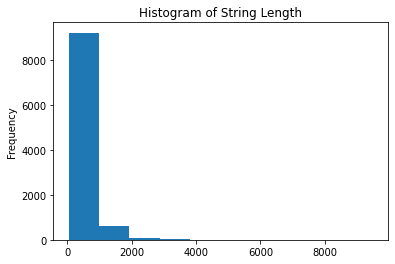

In [10]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of String Length')

In [11]:
reviews['len'] = reviews['Text'].str.len()
reviews = reviews[reviews['len'] < 150][reviews['len'] > 50]

reviews.shape

<ipython-input-11-2448f73769de>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews = reviews[reviews['len'] < 150][reviews['len'] > 50]


(1758, 11)

In [12]:
reviews['Sentiment'] = reviews['Score'].map(lambda x: 'positive'  if x >=  4 else 'negative')

<AxesSubplot:title={'center':'Histogram of String Length'}, ylabel='Frequency'>

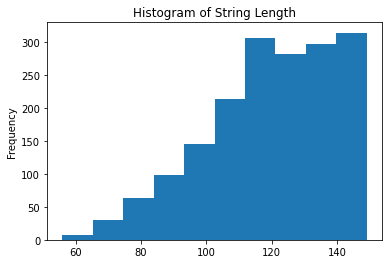

In [13]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of String Length')

<AxesSubplot:>

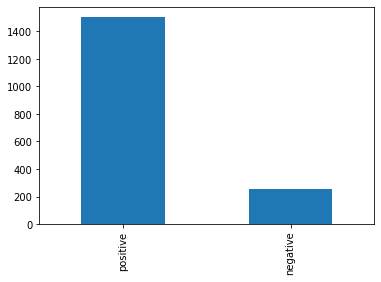

In [14]:
reviews['Sentiment'].value_counts().plot(kind='bar')

In [17]:
reviews_sample = reviews.groupby('Sentiment').sample(200)

reviews_sample.shape

(400, 12)

In [18]:
from transformers import GPT2Tokenizer

MODEL = 'distilgpt2'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token

#add two prompts, one for each task
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'

# Uncomment these lines to add the two tokens to the tokenizer as brand new tokens

# special_words_to_add={"additional_special_tokens": [SENTIMENT_TOKEN, SUMMARIZE_TOKEN]}
# tokenizer.add_special_tokens(special_words_to_add)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


<AxesSubplot:>

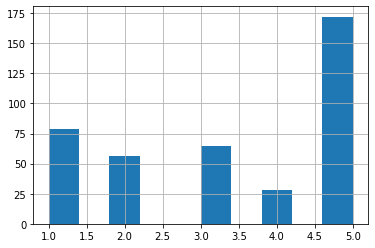

In [19]:
reviews_sample['Score'].hist()

In [24]:
reviews_sample['sentiment_text'] = '<sent>\nReview: ' + reviews_sample['Text'] + SENTIMENT_TOKEN +  ' ' + reviews_sample['Sentiment'].astype(str)

reviews_sample['summarize_text'] = '<summ>\nReview: ' + reviews_sample['Text'] + SUMMARIZE_TOKEN +  ' ' + reviews_sample['Summary'].astype(str)


In [25]:
reviews_sample['sentiment_text'].head(2).tolist()

['<sent>\nReview: I just bought this at the store like for 4 bucks. who ever is selling this is exploiting this big time.\nSentiment: negative',
 '<sent>\nReview: I thought this was going to be like the packets of salsa I get it Sonic with my breakfast burritos.  This is more like taco sauce and not salsa.\nSentiment: negative']

In [26]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>'}

In [27]:
reviews_sample['summarize_text'].head(2).tolist()

['<summ>\nReview: I just bought this at the store like for 4 bucks. who ever is selling this is exploiting this big time.\nSummarize: Over priced',
 '<summ>\nReview: I thought this was going to be like the packets of salsa I get it Sonic with my breakfast burritos.  This is more like taco sauce and not salsa.\nSummarize: Not what I was expecting']

In [29]:
# don't repeat utterances for sentiment or summarize
reviews_sample = reviews_sample.sample(frac=1)

mid_point = reviews_sample.shape[0]//2

training_examples = reviews_sample['summarize_text'].head(mid_point).tolist() + reviews_sample['sentiment_text'].tail(mid_point).tolist()


In [30]:
multi_task_df = pd.DataFrame({'text': training_examples})

multi_task_df.shape

(400, 1)

In [31]:
print(multi_task_df['text'][1])

<summ>
Review: Amazing blend tea.  Powerfully flavorful, for those looking for a 'pick-me-up.'  Not tart, but rather smooth and rich.
Summarize: best tea


In [32]:
print(multi_task_df['text'][10])

<summ>
Review: I'm glad I didn't actually gift this to someone.  The food was mediocre at best and the cutting board split right in half.
Summarize: Not a good gift.


In [33]:
from datasets import Dataset
data = Dataset.from_pandas(multi_task_df)
data

Dataset({
    features: ['text'],
    num_rows: 400
})

In [34]:
MAX_TOKENS = 256

# texts to numeric vectors of MAX_TOKENS
def tokenize_function(examples):
    # tokenizer created input_ids and attention_mask as output
    output = tokenizer(
        examples['text'],
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding='max_length',
    )
    
    output['labels'] =  output["input_ids"]
    # -100 is a reserved value to ignore these tokens when calculating the loss
    output["labels"] = [[-100 if x == tokenizer.pad_token_id else x for x in y] for y in output["labels"]]
    return output

data = data.map(
    tokenize_function,
    batched=True,
)
print(data)


  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'text'],
    num_rows: 400
})


In [35]:
data.set_format(type="python", columns=["input_ids", "attention_mask", "labels"])

data = data.train_test_split(test_size=0.20, shuffle=True, seed=0)
print(data)

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text'],
        num_rows: 320
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text'],
        num_rows: 80
    })
})


In [36]:
tokenizer.decode(data['train'][0]['input_ids'])

'<sent>\nReview: This Halva is one of the best kind, it tastes super fresh and for it being sugar free simply unbelievable its sooo good\nSentiment: positive<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext

In [37]:
tokenizer.decode([c for c  in data['train'][0]['labels'] if c != -100])

'<sent>\nReview: This Halva is one of the best kind, it tastes super fresh and for it being sugar free simply unbelievable its sooo good\nSentiment: positive'

In [38]:
len(data['train'][0]['input_ids'])

256

In [39]:
len(data['train'][0]['labels'])

256

In [40]:
len(data['train'][0]['attention_mask'])

256

In [41]:
from transformers import Trainer, TrainingArguments
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained(MODEL)

# Update the model embeddings with the new vocabulary size IF we added new special tokens
# model.resize_token_embeddings(len(tokenizer))

model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [42]:
training_args = TrainingArguments(
    output_dir="./gpt2_multitask", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=2, # number of training epochs
    per_device_train_batch_size=64, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    warmup_steps=10,  # number of warmup steps for learning rate scheduler,
    weight_decay = 0.05,
    logging_steps=5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
)

In [43]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 80
  Batch size = 64


{'eval_loss': 4.900551795959473,
 'eval_runtime': 66.5909,
 'eval_samples_per_second': 1.201,
 'eval_steps_per_second': 0.03}

In [44]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running training *****
  Num examples = 320
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss
5,4.884200
10,4.285100




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=10, training_loss=4.584645843505859, metrics={'train_runtime': 1883.3723, 'train_samples_per_second': 0.34, 'train_steps_per_second': 0.005, 'total_flos': 41807480094720.0, 'train_loss': 4.584645843505859, 'epoch': 2.0})

In [45]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 80
  Batch size = 64


{'eval_loss': 3.853083848953247,
 'eval_runtime': 77.6228,
 'eval_samples_per_second': 1.031,
 'eval_steps_per_second': 0.026,
 'epoch': 2.0}

In [46]:
trainer.save_model()

Saving model checkpoint to ./gpt2_multitask
Configuration saved in ./gpt2_multitask/config.json
Model weights saved in ./gpt2_multitask/pytorch_model.bin


In [47]:
from transformers import pipeline

loaded_model = GPT2LMHeadModel.from_pretrained('./gpt2_multitask')

generator = pipeline(
    'text-generation', model=loaded_model, tokenizer=tokenizer,
    config={'max_length': 200,  'do_sample': False}
)

loading configuration file ./gpt2_multitask/config.json
Model config GPT2Config {
  "_name_or_path": "distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "float32",
  "transformers_version": "4.10.0",


In [248]:
text_sample, score, summary = reviews_sample.sample(1)[['Text', 'Sentiment', 'Summary']].values[0]

print(text_sample)
print(score)
print(summary)

Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
positive
YUMMY!


In [249]:
num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

30

In [250]:
sentiment_text_sample = f'<sent>\nReview: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'<summ>\nReview: {text_sample}{SUMMARIZE_TOKEN}'

print(sentiment_text_sample)
print(summarize_text_sample)

<sent>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Sentiment:
<summ>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Summarize:


In [255]:
encoded_input = tokenizer(sentiment_text_sample, return_tensors='pt')
    
print(tokenizer.decode(loaded_model.generate(
        input_ids=encoded_input['input_ids'],
        max_length=encoded_input['input_ids'].shape[1] + 1,
        temperature=0.5,
        top_k=10
    )[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<sent>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Sentiment: 5


In [252]:
encoded_input = tokenizer(summarize_text_sample, return_tensors='pt')
    
print(tokenizer.decode(loaded_model.generate(
        input_ids=encoded_input['input_ids'],
        max_length=len(encoded_input['input_ids']) + 50,
        temperature=0.5,
        beams=2,
        top_k=10,
        no_repeat_ngram_size=2,
    )[0], skip_special_tokens=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<summ>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Summarize: I love these cookies and love them!<|endoftext|>


In [253]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=5, max_length=num_tokens + 1):
    print(generated_text['generated_text'])
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 40, but ``max_length`` is set to 31.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


<sent>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Sentiment: 7
<sent>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Sentiment: 12
<sent>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Sentiment: 9
<sent>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Sentiment: Excellent
<sent>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Sentiment: 5


In [254]:
for generated_text in generator(summarize_text_sample, num_return_sequences=5, max_length=num_tokens + 15):
    print(generated_text['generated_text'])
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<summ>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Summarize: I recommend putting
<summ>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Summarize: I have been
<summ>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Summarize: 2
<summ>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Summarize: Perfect size and
<summ>
Review: Yummy! Enough Said. These little cookies are so good. Perfect amount of sweetness, chocate and crispness. Will definitely be ordering again!
Summarize: Delicious! S
